In [17]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [39]:
class PriorityQueue:
    """
    Priority queue data structure for shortest job first
    """
    def __init__(self):
        self.queue = []
    
    def push(self, item):
        self.queue.append(item)
        self._sift_up(len(self.queue) - 1)

    def pop(self):
        if len(self.queue) == 0:
            return None
        if len(self.queue) == 1:
            return self.queue.pop()
        
        top = self.queue[0]
        self.queue[0] = self.queue.pop()
        self._sift_down(0)
        return top

    def _sift_up(self, index):
        parent = (index - 1) // 2
        if parent >= 0 and self.queue[parent] > self.queue[index]:
            self.queue[parent], self.queue[index] = self.queue[index], self.queue[parent]
            self._sift_up(parent)

    def _sift_down(self, index):
        left_child = 2 * index + 1
        right_child = 2 * index + 2
        smallest = index

        if left_child < len(self.queue) and self.queue[left_child] < self.queue[smallest]:
            smallest = left_child
        if right_child < len(self.queue) and self.queue[right_child] < self.queue[smallest]:
            smallest = right_child

        if smallest != index:
            self.queue[index], self.queue[smallest] = self.queue[smallest], self.queue[index]
            self._sift_down(smallest)

    def get(self):
        return self.queue

In [40]:
#### temporary global variable to keep track of service queue length
service_queue_lengths = [] 

class Queue:
    def __init__(self, env, arrival_rate, service_rate, num_servers, sjf = False):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        self.service_queue = PriorityQueue() 
        

    def arrival(self, sjf = False):
        """The arrival process generates customers according to a Poisson process"""
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            
            ### Start a service process
            self.env.process(self.service(sjf))

    def service(self, sjf = False):
        """The service process. The customer arrives and requests a service. The service time follows 
           the exponential distribution"""
        if sjf == False:
            with self.server.request() as req:
                queue_arrival_time= self.env.now
                yield req
                #### calculate waiting time
                waiting_time = self.env.now - queue_arrival_time
                
                service_time = random.expovariate(self.service_rate)
                yield self.env.timeout(service_time)
                
                self.waiting_time_in_the_queue.append(waiting_time)

        else:
            while True:
                yield self.env.timeout(0)  # release control to allow other processes to run
                with self.server.request() as req:
                    queue_arrival_time = self.env.now
                    service_time = random.expovariate(self.service_rate)
                    #### add customer to a service queue
                    self.service_queue.push((service_time, queue_arrival_time))

                    yield req
                    
                    #### track service queue length
                    service_queue_lengths.append(len(self.service_queue.get()))

                    #### if the current job is shortest - serve
                    shortest_job = self.service_queue.pop()
                    if shortest_job[1] == queue_arrival_time:
                        waiting_time = self.env.now - queue_arrival_time
                        yield self.env.timeout(shortest_job[0])
                        self.waiting_time_in_the_queue.append(waiting_time)

In [41]:
def run_simulations(arrival_rate, service_rate, sim_time, num_simulations, num_servers, full_output = False, sjf = False):
    """Setup, simulate and plot sample mean waiting time against the simulation time"""
    all_means_waiting_time= []
    
    for i in range(num_simulations):
        
        env = simpy.Environment()
        my_queue = Queue(env, arrival_rate, service_rate, num_servers)
        env.process(my_queue.arrival(sjf))
        env.run(until=sim_time)
        
        means = []  # collect means for one silmulation over sim_time
        
        for i in range(1, sim_time + 1):
            subset_data=my_queue.waiting_time_in_the_queue[:i]
            mean = np.mean(subset_data)
            means.append(mean)            
            
        all_means_waiting_time.append(means)

    if full_output:
        return all_means_waiting_time, all_means_waiting_time
    else:
        return np.mean(all_means_waiting_time, axis=0), np.std(all_means_waiting_time, axis=0)

In [42]:
"""may be outdated"""
def setup(arrival_rate, service_rate, sim_time, num_servers, sjf = False):
    """Setup and start the simulation and returns average waiting time in one simulation"""
    env = simpy.Environment()
    M_M_n = Queue(env, arrival_rate, service_rate, num_servers, sjf)
    env.process(M_M_n.arrival(sjf))
    env.run(until=sim_time)
    average_waiting_time = sum(M_M_n.waiting_time_in_the_queue) / len(M_M_n.waiting_time_in_the_queue)

    return average_waiting_time, len(M_M_n.waiting_time_in_the_queue)

def simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, sjf = False):
    """Returns average waiting time over provided number of simulations"""
    average_waiting_time_list = []
    for i in range(num_simulations):
        average_waiting_time, N_customers = setup(arrival_rate, service_rate, sim_time, num_servers, sjf)
        average_waiting_time_list.append(average_waiting_time)
        
    average_waiting_time_over_simulations = sum(average_waiting_time_list) / num_simulations

    print(f' Average waiting time in the queue with number of servers ={num_servers} over {num_simulations} simulations: {average_waiting_time_over_simulations}')
    return average_waiting_time_over_simulations, N_customers

In [43]:
"""may be outdated"""

arrival_rate = 1  #average time between arrivals is 0.2 minutes, or on average 5 people arrive every minute, so the rate=5
service_rate = 0.9   # average service time is 5 minutes, so the rate is 1/5 

simulation_time = 100
num_simulations = 10
num_servers = 2

_, n1 = simulate(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, sjf = True)
_, n2 = simulate(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, sjf = False)

print(n1, n2)

 Average waiting time in the queue with number of servers =2 over 10 simulations: 0.1385009825727504
 Average waiting time in the queue with number of servers =2 over 10 simulations: 0.35219309124654574
149 104


Text(0, 0.5, 'srvice queue length')

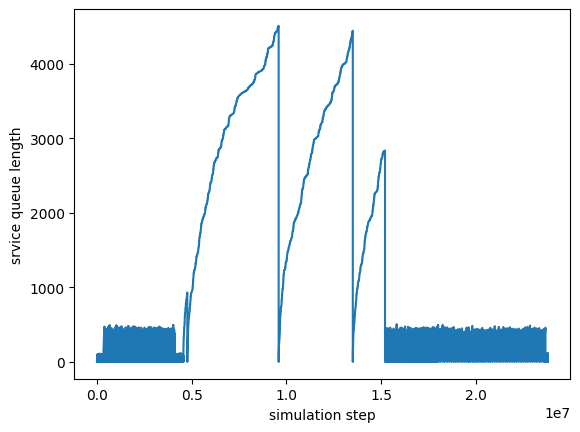

In [27]:
plt.plot(service_queue_lengths)
plt.xlabel('simulation step')
plt.ylabel('srvice queue length')

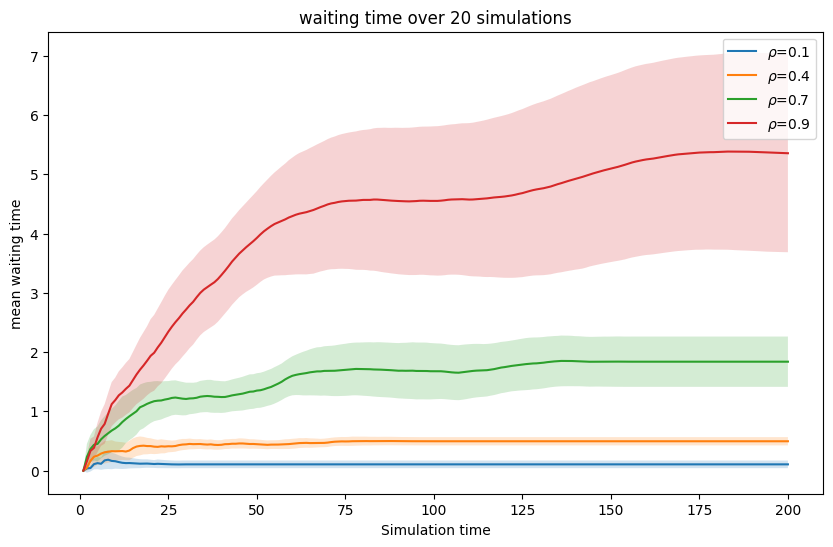

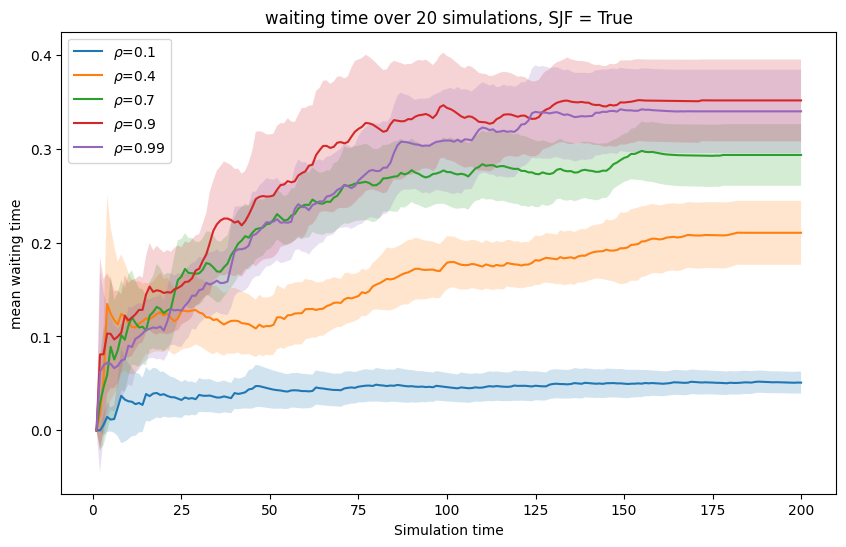

In [21]:

simulation_time = 200
num_servers= 1
num_simulations = 20
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values

plt.figure(figsize=(10, 6))

for arrival_rate in [0.1, 0.4, 0.7, 0.9]:
    means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

plt.ylabel("mean waiting time")
plt.xlabel("Simulation time")
plt.legend()
plt.title(f"waiting time over {num_simulations} simulations")


plt.figure(figsize=(10, 6))

for arrival_rate in [0.1, 0.4, 0.7, 0.9, 0.99]:
    means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers, sjf = True)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

plt.ylabel("mean waiting time")
plt.xlabel("Simulation time")
plt.legend()
plt.title(f"waiting time over {num_simulations} simulations, SJF = True")


#plt.savefig('.png', dpi=300)
plt.show()


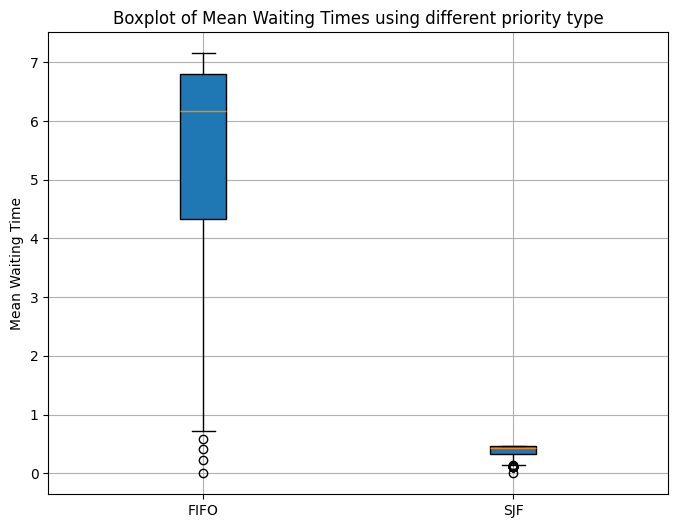

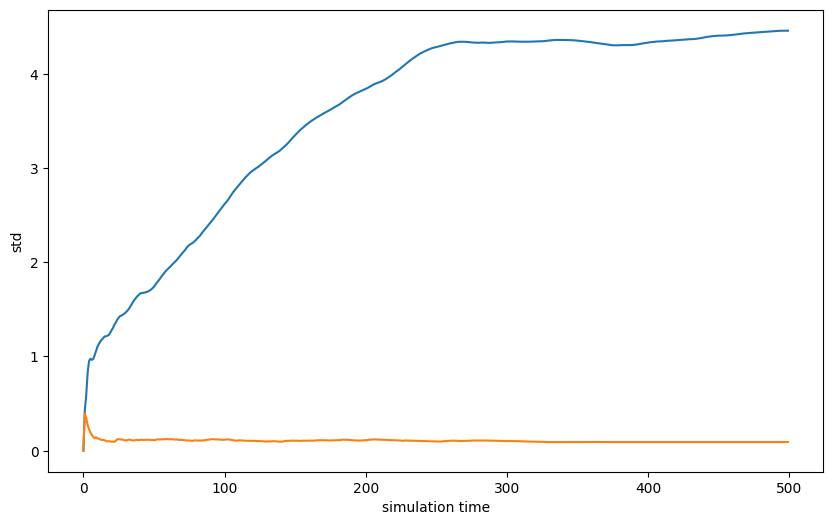

In [33]:
simulation_time = 500
num_servers= 1
num_simulations = 50
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values
arrival_rate = 0.9

means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers)

means_sjf, st_devs_sjf= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers, sjf = True)

plt.figure(figsize=(8, 6))
plt.boxplot([means, means_sjf], patch_artist=True)
plt.ylabel('Mean Waiting Time')
plt.title('Boxplot of Mean Waiting Times using different priority type')
plt.xticks(ticks=[1,2], labels=['FIFO', 'SJF'])
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.ylabel('std')
plt.xlabel('simulation time')
plt.plot(st_devs)
plt.plot(st_devs_sjf)

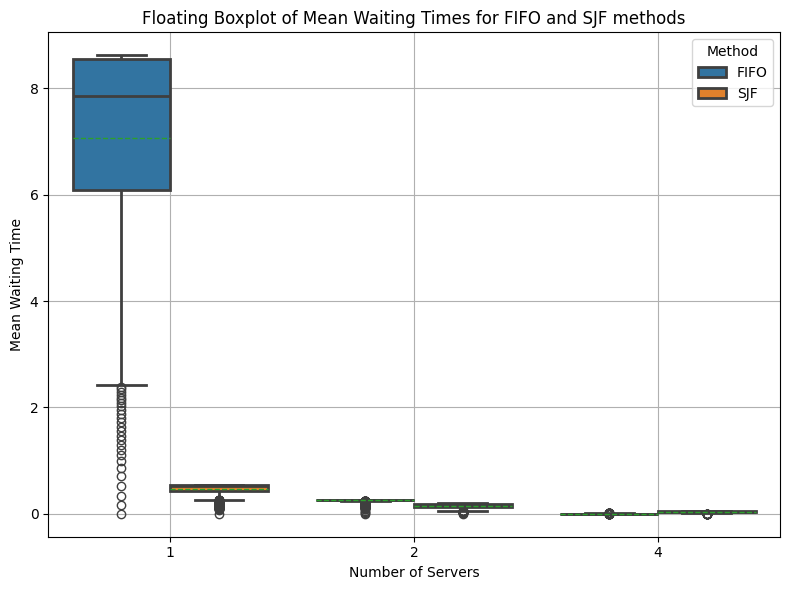

In [32]:
simulation_time = 1000
num_simulations = 100
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values
arrival_rate = 0.9
num_servers = [1, 2, 4]

fifo_data = {}
sjf_data = {}
for server in num_servers:
    fifo_data[server] = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, server)[0]
    sjf_data[server] = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, server, sjf=True)[0]

# Formatting data into DataFrame for Seaborn
data = []

for method, method_data in [('FIFO', fifo_data), ('SJF', sjf_data)]:
    for num_servers, values in method_data.items():
        for value in values:
            data.append({'Method': method, 'Num_Servers': num_servers, 'Mean Waiting Time': value})

# Formatting data into DataFrame for Seaborn
data = []
for method, method_data in [(method, method_data) for method, method_data in [('FIFO', fifo_data), ('SJF', sjf_data)]]:
    for num_servers, values in method_data.items():
        for value in values:
            data.append({'Method': method, 'Num_Servers': num_servers, 'Mean Waiting Time': value})

df = pd.DataFrame(data)

# Creating floating boxplots with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='Num_Servers', y='Mean Waiting Time', hue='Method', data=df, showmeans=True, meanline=True, linewidth=2)
plt.xlabel('Number of Servers')
plt.ylabel('Mean Waiting Time')
plt.title('Floating Boxplot of Mean Waiting Times for FIFO and SJF methods')
plt.legend(title='Method')
plt.grid(True)
plt.tight_layout()
plt.show()

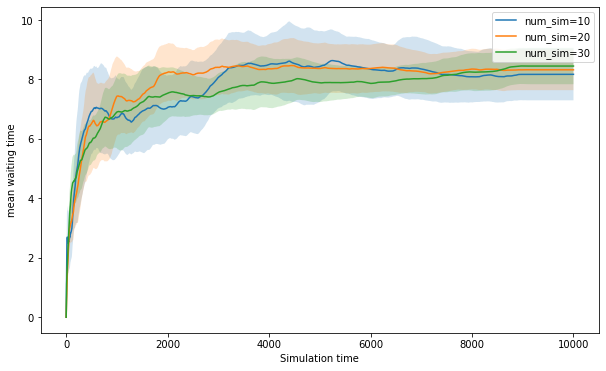

In [66]:
simulation_time = 10000 
num_servers= 1
service_rate =1
arrival_rate= 0.9  #so rho=0.9

plt.figure(figsize=(10, 6))

for num_simulations in [10, 20, 30]:
    means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'num_sim=' + f'{num_simulations}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

plt.ylabel("mean waiting time")
plt.xlabel("Simulation time")
plt.legend()
plt.show()